In [146]:
import pandas as pd
from sqlalchemy import create_engine, text
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [147]:
db_user = 'postgres'
db_password = '123456'
db_host = 'localhost'
db_port = '5432'
db_name = 'nordic_co2'

engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Iceland

## General Analysis

In [148]:
query_is_general = '''
WITH is_2021_summary AS (
    SELECT 
        '2021' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM iceland.year_2021_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), is_2022_summary AS (
    SELECT 
        '2022' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM iceland.year_2022_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), is_2023_summary AS (
    SELECT 
        '2023' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM iceland.year_2023_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), is_2024_summary AS (
    SELECT 
        '2024' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM iceland.year_2024_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), total_summary AS (
    SELECT * FROM is_2021_summary
    UNION ALL
    SELECT * FROM is_2022_summary
    UNION ALL
    SELECT * FROM is_2023_summary
    UNION ALL
    SELECT * FROM is_2024_summary
), with_differences AS (
    SELECT 
        *,
        LEAD(total_direct_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, month_grouped) AS next_direct_carbon_emission,
        LEAD(total_lca_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, month_grouped) AS next_lca_carbon_emission
    FROM total_summary
)

SELECT 
    year_,
    country,
    zone_id,
    month_grouped,
    total_direct_carbon_emission,
    next_direct_carbon_emission,
    CASE 
        WHEN next_direct_carbon_emission IS NOT NULL AND total_direct_carbon_emission != 0 
        THEN ROUND(((next_direct_carbon_emission - total_direct_carbon_emission) / total_direct_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS direct_decrease_or_increase,
    total_lca_carbon_emission,
    next_lca_carbon_emission,
    CASE 
        WHEN next_lca_carbon_emission IS NOT NULL AND total_lca_carbon_emission != 0 
        THEN ROUND(((next_lca_carbon_emission - total_lca_carbon_emission) / total_lca_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS lca_decrease_or_increase,
    avg_renewable_percentage,
    avg_low_carbon_percentage
FROM with_differences
ORDER BY year_, month_grouped;
'''

is_general = pd.read_sql_query(query_is_general, engine)

In [149]:
is_general.head()

,year_,country,zone_id,month_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Iceland,IS,1.0,0.88,0.94,6.82,20877.22,18872.85,-9.60,100.0,100.0
1,2021,Iceland,IS,2.0,0.94,1.10,17.02,18872.85,20864.50,10.55,100.0,100.0
2,2021,Iceland,IS,3.0,1.10,0.87,-20.91,20864.50,20114.03,-3.60,100.0,100.0
3,2021,Iceland,IS,4.0,0.87,0.46,-47.13,20114.03,20508.28,1.96,100.0,100.0
4,2021,Iceland,IS,5.0,0.46,0.95,106.52,20508.28,20053.28,-2.22,100.0,100.0


In [150]:
is_general.rename(columns={'year_':'year'}, inplace=True)
is_general.rename(columns={'month_grouped':'month'}, inplace=True)

In [151]:
is_general.dtypes

year                             object
country                          object
zone_id                          object
month                           float64
total_direct_carbon_emission    float64
next_direct_carbon_emission     float64
direct_decrease_or_increase     float64
total_lca_carbon_emission       float64
next_lca_carbon_emission        float64
lca_decrease_or_increase        float64
avg_renewable_percentage        float64
avg_low_carbon_percentage       float64
dtype: object

In [152]:
is_general.year = is_general.year.astype(int)
is_general.month = is_general.month.astype(int)

### Statistics

In [153]:
is_general.describe()

,year,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
count,48.000000,48.000000,48.000000,47.000000,13.000000,48.000000,47.000000,47.000000,48.000000,48.000000
mean,2022.500000,6.500000,6.808542,6.934681,-29.392308,20314.078333,20302.096596,0.132128,99.997708,99.997708
std,1.129865,3.488583,21.104205,21.314068,66.333324,642.910106,644.420772,5.008886,0.007217,0.007217
min,2021.000000,1.000000,0.000000,0.000000,-100.000000,18253.730000,18253.730000,-10.950000,99.960000,99.960000
25%,2021.750000,3.750000,0.000000,0.000000,-100.000000,20052.357500,20051.435000,-3.345000,100.000000,100.000000
50%,2022.500000,6.500000,0.000000,0.000000,-36.210000,20294.530000,20288.870000,-0.330000,100.000000,100.000000
75%,2023.250000,9.250000,0.562500,0.230000,6.820000,20869.795000,20865.910000,3.935000,100.000000,100.000000
max,2024.000000,12.000000,113.790000,113.790000,106.520000,21115.560000,21115.560000,10.950000,100.000000,100.000000


<Axes: >

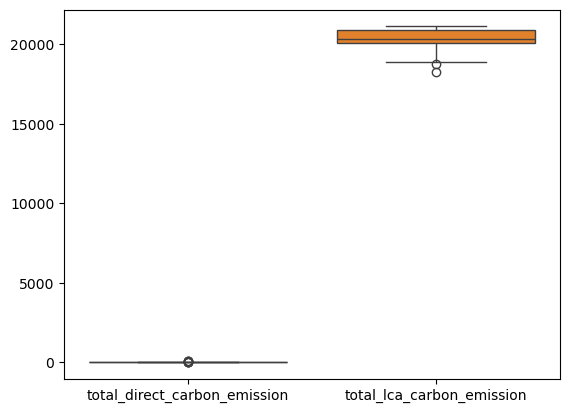

In [154]:
sns.boxplot(is_general[['total_direct_carbon_emission', 'total_lca_carbon_emission']])

<Axes: >

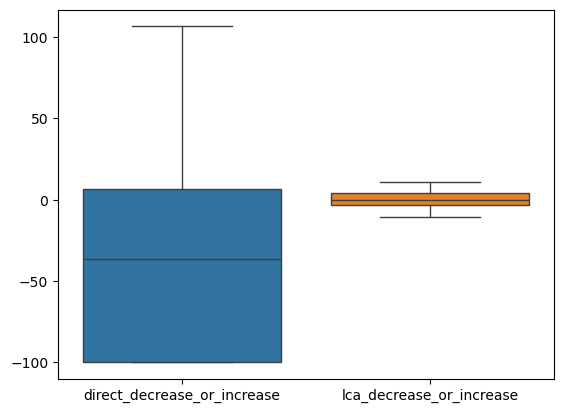

In [155]:
sns.boxplot(is_general[['direct_decrease_or_increase', 'lca_decrease_or_increase']])

In [156]:
is_general[is_general['direct_decrease_or_increase'] > 100]

,year,country,zone_id,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
4,2021,Iceland,IS,5,0.46,0.95,106.52,20508.28,20053.28,-2.22,100.0,100.0


In [157]:
is_general.loc[[33, 34]]

,year,country,zone_id,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
33,2023,Iceland,IS,10,0.0,0.0,NaN,20947.36,20245.16,-3.35,100.0,100.0
34,2023,Iceland,IS,11,0.0,0.0,NaN,20245.16,20966.79,3.56,100.0,100.0


In [158]:
is_general.select_dtypes(include='number').corr()

,year,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
year,1.000000e+00,4.864312e-14,-0.218982,-0.273275,-0.152597,0.187398,0.178714,0.007763,0.221792,0.221792
month,4.864312e-14,1.000000e+00,-0.271349,-0.126454,-0.399707,0.161677,0.355395,0.122458,0.240851,0.240851
total_direct_carbon_emission,-2.189816e-01,-2.713494e-01,1.000000,0.641386,-0.043809,-0.147078,-0.136277,0.021495,-0.991500,-0.991500
next_direct_carbon_emission,-2.732752e-01,-1.264537e-01,0.641386,1.000000,0.387326,0.062570,-0.143051,-0.118569,-0.603951,-0.603951
direct_decrease_or_increase,-1.525965e-01,-3.997066e-01,-0.043809,0.387326,1.000000,0.108290,-0.301197,-0.204534,0.094839,0.094839
total_lca_carbon_emission,1.873979e-01,1.616773e-01,-0.147078,0.062570,0.108290,1.000000,-0.202701,-0.788128,0.165022,0.165022
next_lca_carbon_emission,1.787144e-01,3.553946e-01,-0.136277,-0.143051,-0.301197,-0.202701,1.000000,0.761530,0.112999,0.112999
lca_decrease_or_increase,7.762587e-03,1.224579e-01,0.021495,-0.118569,-0.204534,-0.788128,0.761530,1.000000,-0.047628,-0.047628
avg_renewable_percentage,2.217915e-01,2.408510e-01,-0.991500,-0.603951,0.094839,0.165022,0.112999,-0.047628,1.000000,1.000000
avg_low_carbon_percentage,2.217915e-01,2.408510e-01,-0.991500,-0.603951,0.094839,0.165022,0.112999,-0.047628,1.000000,1.000000


In [159]:
#sns.pairplot(is_general)

## Hourly Analysis

In [160]:
query_is_hourly = '''
WITH is_2021_summary AS (
    SELECT 
        '2021' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM iceland.year_2021_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), is_2022_summary AS (
    SELECT 
        '2022' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM iceland.year_2022_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), is_2023_summary AS (
    SELECT 
        '2023' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM iceland.year_2023_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), is_2024_summary AS (
    SELECT 
        '2024' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM iceland.year_2024_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), total_summary AS (
    SELECT * FROM is_2021_summary
    UNION ALL
    SELECT * FROM is_2022_summary
    UNION ALL
    SELECT * FROM is_2023_summary
    UNION ALL
    SELECT * FROM is_2024_summary
), with_differences AS (
    SELECT 
        *,
        LEAD(total_direct_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, hour_grouped) AS next_direct_carbon_emission,
        LEAD(total_lca_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, hour_grouped) AS next_lca_carbon_emission
    FROM total_summary
)

SELECT 
    year_,
    country,
    zone_id,
    hour_grouped,
    total_direct_carbon_emission,
    next_direct_carbon_emission,
    CASE 
        WHEN next_direct_carbon_emission IS NOT NULL AND total_direct_carbon_emission != 0 
        THEN ROUND(((next_direct_carbon_emission - total_direct_carbon_emission) / total_direct_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS direct_decrease_or_increase,
    total_lca_carbon_emission,
    next_lca_carbon_emission,
    CASE 
        WHEN next_lca_carbon_emission IS NOT NULL AND total_lca_carbon_emission != 0 
        THEN ROUND(((next_lca_carbon_emission - total_lca_carbon_emission) / total_lca_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS lca_decrease_or_increase,
    avg_renewable_percentage,
    avg_low_carbon_percentage
FROM with_differences
ORDER BY year_, hour_grouped
'''

is_hourly = pd.read_sql_query(query_is_hourly, engine)

In [161]:
is_hourly.head(20)

,year_,country,zone_id,hour_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Iceland,IS,0.0,0.02,0.74,3600.00,10201.46,10212.11,0.10,100.00,100.00
1,2021,Iceland,IS,1.0,0.74,0.84,13.51,10212.11,10216.60,0.04,100.00,100.00
2,2021,Iceland,IS,2.0,0.84,1.02,21.43,10216.60,10220.07,0.03,100.00,100.00
3,2021,Iceland,IS,3.0,1.02,1.00,-1.96,10220.07,10220.87,0.01,100.00,100.00
4,2021,Iceland,IS,4.0,1.00,1.11,11.00,10220.87,10218.04,-0.03,100.00,100.00
5,2021,Iceland,IS,5.0,1.11,1.31,18.02,10218.04,10207.86,-0.10,100.00,100.00
6,2021,Iceland,IS,6.0,1.31,1.61,22.90,10207.86,10187.41,-0.20,100.00,100.00
7,2021,Iceland,IS,7.0,1.61,1.86,15.53,10187.41,10160.42,-0.26,100.00,100.00
8,2021,Iceland,IS,8.0,1.86,4.80,158.06,10160.42,10148.05,-0.12,100.00,100.00
9,2021,Iceland,IS,9.0,4.80,6.34,32.08,10148.05,10143.92,-0.04,100.00,100.00


In [162]:
is_hourly

,year_,country,zone_id,hour_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Iceland,IS,0.0,0.02,0.74,3600.00,10201.46,10212.11,0.10,100.0,100.0
1,2021,Iceland,IS,1.0,0.74,0.84,13.51,10212.11,10216.60,0.04,100.0,100.0
2,2021,Iceland,IS,2.0,0.84,1.02,21.43,10216.60,10220.07,0.03,100.0,100.0
3,2021,Iceland,IS,3.0,1.02,1.00,-1.96,10220.07,10220.87,0.01,100.0,100.0
4,2021,Iceland,IS,4.0,1.00,1.11,11.00,10220.87,10218.04,-0.03,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...
91,2024,Iceland,IS,19.0,0.00,0.00,NaN,10276.56,10284.95,0.08,100.0,100.0
92,2024,Iceland,IS,20.0,0.00,0.00,NaN,10284.95,10296.72,0.11,100.0,100.0
93,2024,Iceland,IS,21.0,0.00,0.00,NaN,10296.72,10311.09,0.14,100.0,100.0
94,2024,Iceland,IS,22.0,0.00,0.00,NaN,10311.09,10328.42,0.17,100.0,100.0


In [163]:
is_hourly.rename(columns={'year_':'year'}, inplace=True)
is_hourly.rename(columns={'hour_grouped':'hour'}, inplace=True)

In [164]:
is_hourly.year = is_hourly.year.astype(int)
is_hourly.hour = is_hourly.hour.astype(int)

In [165]:
#is_hourly.to_excel('is_hourly.xlsx')

In [166]:
is_hourly.describe()

,year,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
count,96.000000,96.000000,96.000000,95.000000,46.000000,96.000000,95.000000,95.000000,96.000000,96.000000
mean,2022.500000,11.500000,3.404271,3.439895,76.947826,10157.039167,10156.571579,0.013368,99.998125,99.998125
std,1.123903,6.958524,4.878484,4.891796,532.634319,110.718212,111.210250,0.305275,0.003924,0.003924
min,2021.000000,0.000000,0.000000,0.000000,-100.000000,9979.050000,9979.050000,-1.510000,99.990000,99.990000
25%,2021.750000,5.750000,0.000000,0.000000,-14.682500,10088.400000,10076.520000,-0.060000,100.000000,100.000000
50%,2022.500000,11.500000,0.000000,0.000000,-0.150000,10149.980000,10149.550000,0.010000,100.000000,100.000000
75%,2023.250000,17.250000,6.715000,6.720000,17.082500,10233.202500,10245.535000,0.060000,100.000000,100.000000
max,2024.000000,23.000000,17.770000,17.770000,3600.000000,10370.870000,10370.870000,1.910000,100.000000,100.000000


<Axes: >

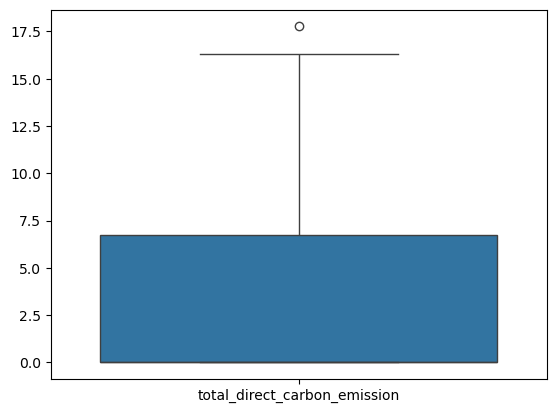

In [167]:
sns.boxplot(is_hourly[['total_direct_carbon_emission']])

<Axes: >

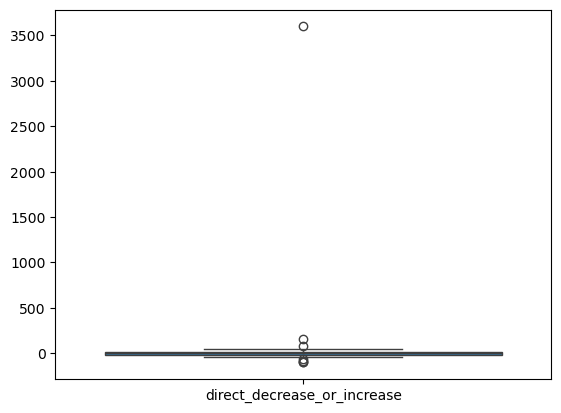

In [168]:
sns.boxplot(is_hourly[['direct_decrease_or_increase']])

In [169]:
is_hourly.select_dtypes(include='number').corr()

,year,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
year,1.000000e+00,2.451147e-14,-0.471155,-0.479898,-0.156483,0.541213,0.546396,0.078317,0.310316,0.310316
hour,2.451147e-14,1.000000e+00,0.030802,-0.008249,-0.281711,-0.181602,-0.152971,0.211366,-0.084820,-0.084820
total_direct_carbon_emission,-4.711549e-01,3.080184e-02,1.000000,0.948878,-0.222856,-0.711655,-0.702149,0.002640,-0.853339,-0.853339
next_direct_carbon_emission,-4.798981e-01,-8.248970e-03,0.948878,1.000000,-0.167461,-0.680139,-0.711124,-0.139655,-0.813178,-0.813178
direct_decrease_or_increase,-1.564833e-01,-2.817107e-01,-0.222856,-0.167461,1.000000,0.205594,0.212707,0.018368,0.121419,0.121419
total_lca_carbon_emission,5.412127e-01,-1.816019e-01,-0.711655,-0.680139,0.205594,1.000000,0.960859,-0.098263,0.533560,0.533560
next_lca_carbon_emission,5.463958e-01,-1.529710e-01,-0.702149,-0.711124,0.212707,0.960859,1.000000,0.181258,0.542795,0.542795
lca_decrease_or_increase,7.831685e-02,2.113660e-01,0.002640,-0.139655,0.018368,-0.098263,0.181258,1.000000,0.057552,0.057552
avg_renewable_percentage,3.103164e-01,-8.481952e-02,-0.853339,-0.813178,0.121419,0.533560,0.542795,0.057552,1.000000,1.000000
avg_low_carbon_percentage,3.103164e-01,-8.481952e-02,-0.853339,-0.813178,0.121419,0.533560,0.542795,0.057552,1.000000,1.000000


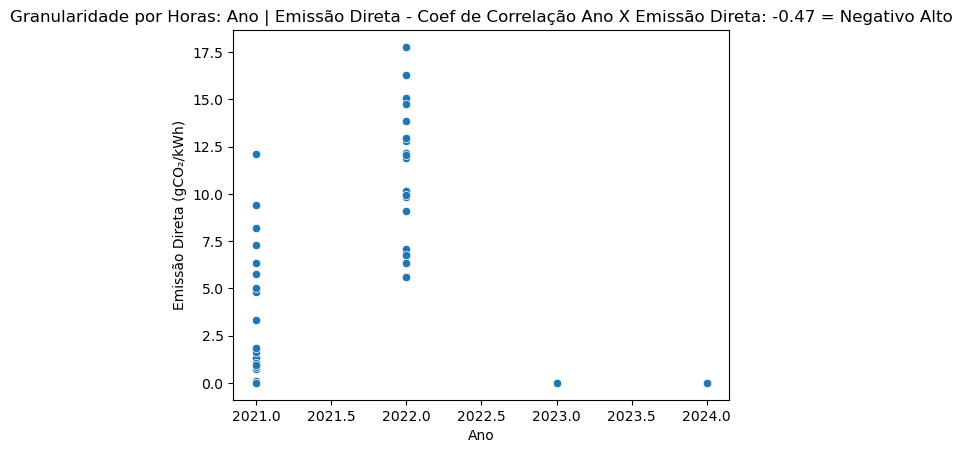

In [170]:
correlation = is_hourly.year.corr(is_hourly.total_direct_carbon_emission)

sns.scatterplot(data=is_hourly, x='year', y='total_direct_carbon_emission')
plt.title(f'Granularidade por Horas: Ano | Emissão Direta - Coef de Correlação Ano X Emissão Direta: {correlation:.2f} = Negativo Alto')
plt.xlabel('Ano')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.show()

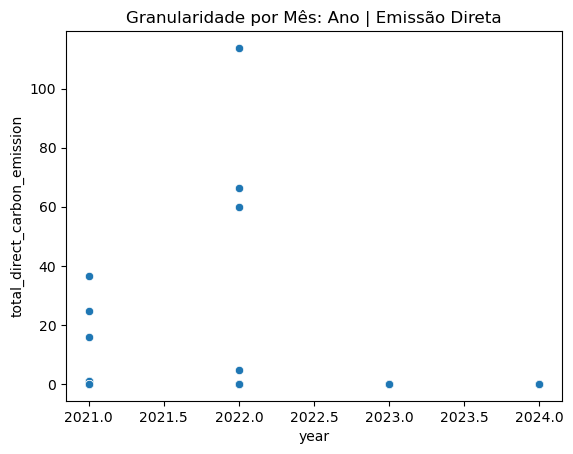

In [171]:
sns.scatterplot(data=is_general, x='year', y='total_direct_carbon_emission')
plt.title('Granularidade por Mês: Ano | Emissão Direta')
plt.show()

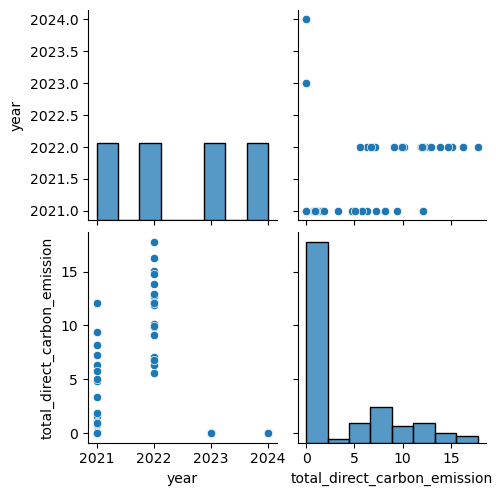

In [172]:
sns.pairplot(is_hourly[['year', 'total_direct_carbon_emission']])

In [ ]:
is_hourly[is_hourly['avg_low_carbon_percentage'] < 99]

,year,country,zone_id,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage


In [192]:
is_hourly[is_hourly['avg_renewable_percentage'] < 99]

,year,country,zone_id,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage


### 2021

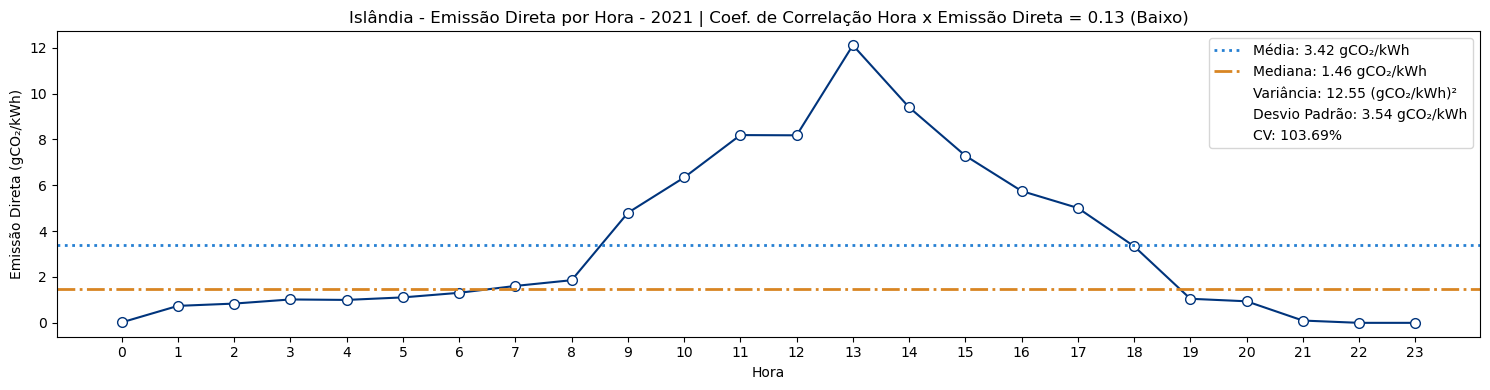

In [173]:
is_hourly_2021 = is_hourly[is_hourly.year == 2021]

correlation = is_hourly_2021.hour.corr(is_hourly_2021.total_direct_carbon_emission)
mean = is_hourly_2021.total_direct_carbon_emission.mean()
median = is_hourly_2021.total_direct_carbon_emission.median()
std = is_hourly_2021.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(is_hourly_2021.hour, is_hourly_2021.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Islândia - Emissão Direta por Hora - 2021 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

In [ ]:
# is_hourly_2021 = is_hourly[is_hourly.year == 2021]

# correlation_renewable = is_hourly_2021.hour.corr(is_hourly_2021.avg_renewable_percentage)
# correlation_low_carbon = is_hourly_2021.hour.corr(is_hourly_2021.avg_low_carbon_percentage)

# plt.figure(figsize=(15, 6))
# plt.subplots_adjust(top=0.90)

# plt.plot(is_hourly_2021.hour, is_hourly_2021.avg_renewable_percentage, 
#          linewidth=1.5, color='green', marker='o', markersize=7, 
#          markerfacecolor='white', markeredgewidth=1)

# for x, y in zip(is_hourly_2021.hour, is_hourly_2021.avg_renewable_percentage):
#     plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='green')

# plt.plot(is_hourly_2021.hour, is_hourly_2021.avg_low_carbon_percentage, 
#          linewidth=1.5, color='red', marker='o', markersize=7, 
#          markerfacecolor='white', markeredgewidth=1)

# for x, y in zip(is_hourly_2021.hour, is_hourly_2021.avg_low_carbon_percentage):
#     plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='red')

# custom_lines = [
#     Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
#     Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
# ]

# plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

# plt.title(
#     f'Islândia - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2021\n'
#     f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
#     f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
# )
# plt.xlabel('Hora')
# plt.ylabel('Porcentagem de Sustentabilidade')
# plt.xticks(range(24))
# plt.tight_layout()
# plt.show()

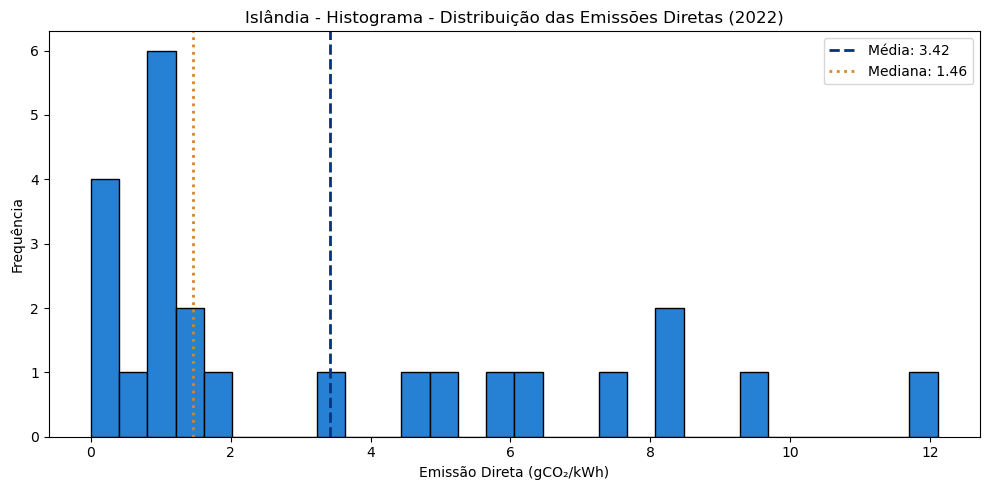

In [175]:
plt.figure(figsize=(10, 5))
plt.hist(is_hourly_2021.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(is_hourly_2021.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {is_hourly_2021.total_direct_carbon_emission.mean():.2f}')
plt.axvline(is_hourly_2021.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {is_hourly_2021.total_direct_carbon_emission.median():.2f}')
plt.title('Islândia - Histograma - Distribuição das Emissões Diretas (2022)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

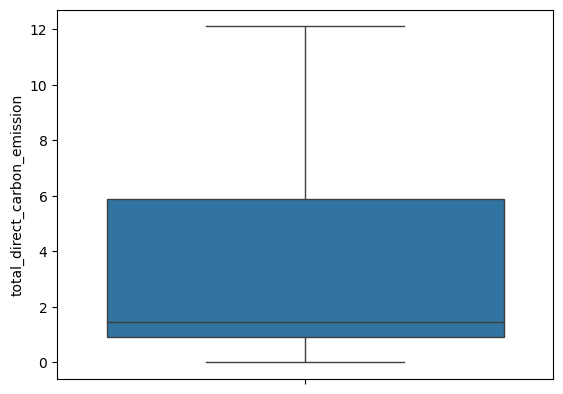

In [176]:
sns.boxplot(is_hourly_2021.total_direct_carbon_emission)

In [177]:
is_hourly.groupby('hour')['total_direct_carbon_emission'].max().reset_index().sort_values('total_direct_carbon_emission', ascending=False)

,hour,total_direct_carbon_emission
10,10,17.77
9,9,16.30
11,11,15.08
12,12,14.73
8,8,13.86
16,16,12.95
13,13,12.77
7,7,12.18
15,15,12.04
14,14,11.91


### 2022

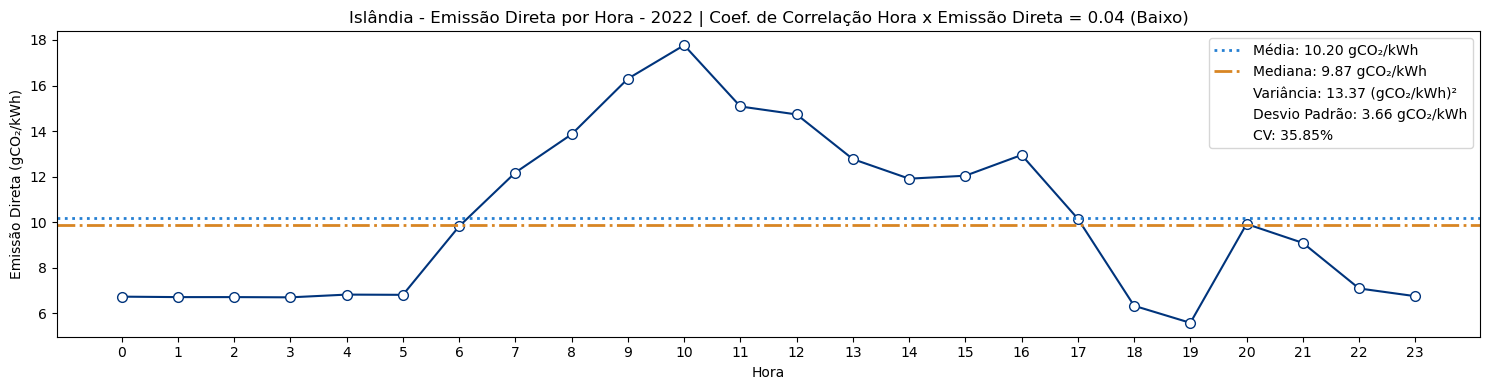

In [178]:
is_hourly_2022 = is_hourly[is_hourly.year == 2022]

correlation = is_hourly_2022.hour.corr(is_hourly_2022.total_direct_carbon_emission)
mean = is_hourly_2022.total_direct_carbon_emission.mean()
median = is_hourly_2022.total_direct_carbon_emission.median()
std = is_hourly_2022.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(is_hourly_2022.hour, is_hourly_2022.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Islândia - Emissão Direta por Hora - 2022 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

In [ ]:
# is_hourly_2022 = is_hourly[is_hourly.year == 2022]

# correlation_renewable = is_hourly_2022.hour.corr(is_hourly_2022.avg_renewable_percentage)
# correlation_low_carbon = is_hourly_2022.hour.corr(is_hourly_2022.avg_low_carbon_percentage)

# plt.figure(figsize=(15, 6))
# plt.subplots_adjust(top=0.90)

# plt.plot(is_hourly_2022.hour, is_hourly_2022.avg_renewable_percentage, 
#          linewidth=1.5, color='green', marker='o', markersize=7, 
#          markerfacecolor='white', markeredgewidth=1)

# for x, y in zip(is_hourly_2022.hour, is_hourly_2022.avg_renewable_percentage):
#     plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='green')

# plt.plot(is_hourly_2022.hour, is_hourly_2022.avg_low_carbon_percentage, 
#          linewidth=1.5, color='red', marker='o', markersize=7, 
#          markerfacecolor='white', markeredgewidth=1)

# for x, y in zip(is_hourly_2022.hour, is_hourly_2022.avg_low_carbon_percentage):
#     plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='red')

# custom_lines = [
#     Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
#     Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
# ]

# plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

# plt.title(
#     f'Islândia - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2022\n'
#     f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
#     f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
# )
# plt.xlabel('Hora')
# plt.ylabel('Porcentagem de Sustentabilidade')
# plt.xticks(range(24))
# plt.tight_layout()
# plt.show()

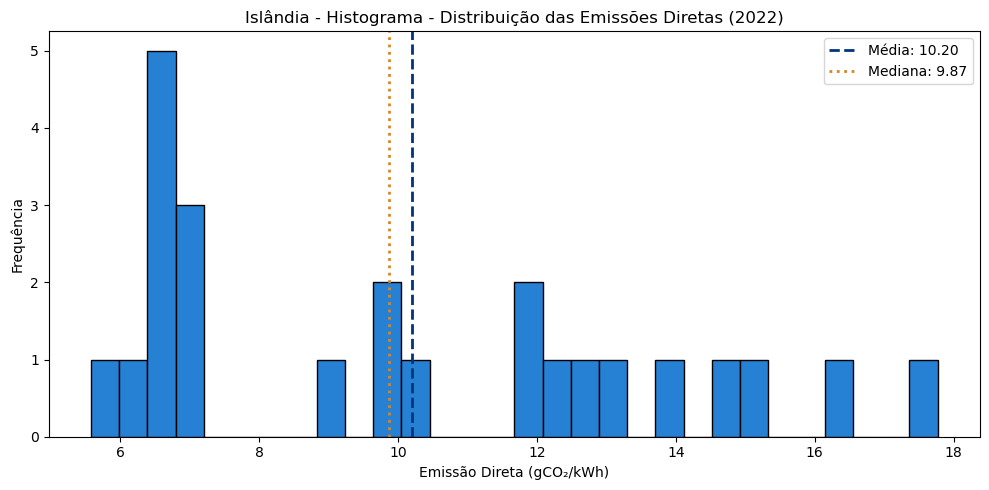

In [180]:
plt.figure(figsize=(10, 5))
plt.hist(is_hourly_2022.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(is_hourly_2022.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {is_hourly_2022.total_direct_carbon_emission.mean():.2f}')
plt.axvline(is_hourly_2022.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {is_hourly_2022.total_direct_carbon_emission.median():.2f}')
plt.title('Islândia - Histograma - Distribuição das Emissões Diretas (2022)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

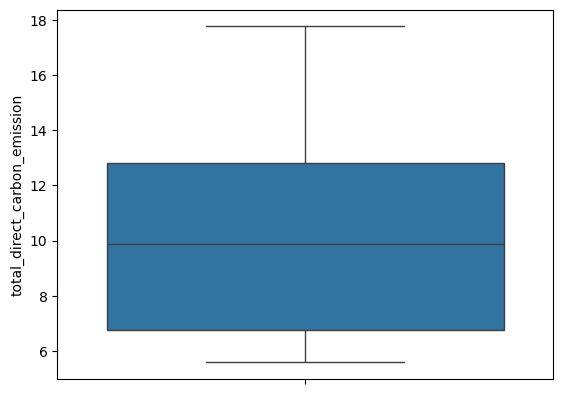

In [181]:
sns.boxplot(is_hourly_2022.total_direct_carbon_emission)

### 2023

c:\Users\mathb\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mathb\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mathb\AppData\Local\Temp\ipykernel_16424\3583701355.py:8: RuntimeWarning: invalid value encountered in scalar divide
  cv = (std/mean)*100


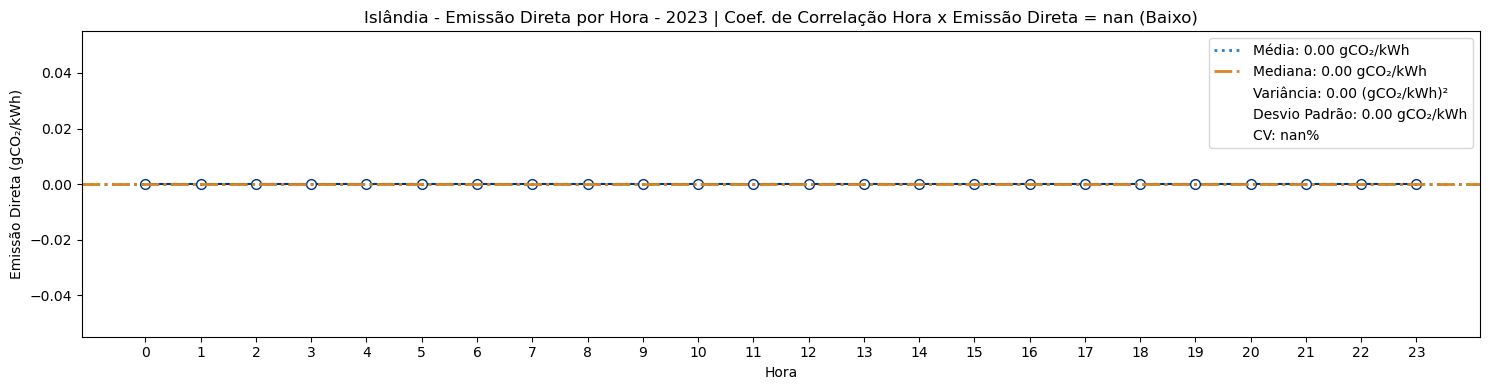

In [182]:
is_hourly_2023 = is_hourly[is_hourly.year == 2023]

correlation = is_hourly_2023.hour.corr(is_hourly_2023.total_direct_carbon_emission)
mean = is_hourly_2023.total_direct_carbon_emission.mean()
median = is_hourly_2023.total_direct_carbon_emission.median()
std = is_hourly_2023.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(is_hourly_2023.hour, is_hourly_2023.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Islândia - Emissão Direta por Hora - 2023 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

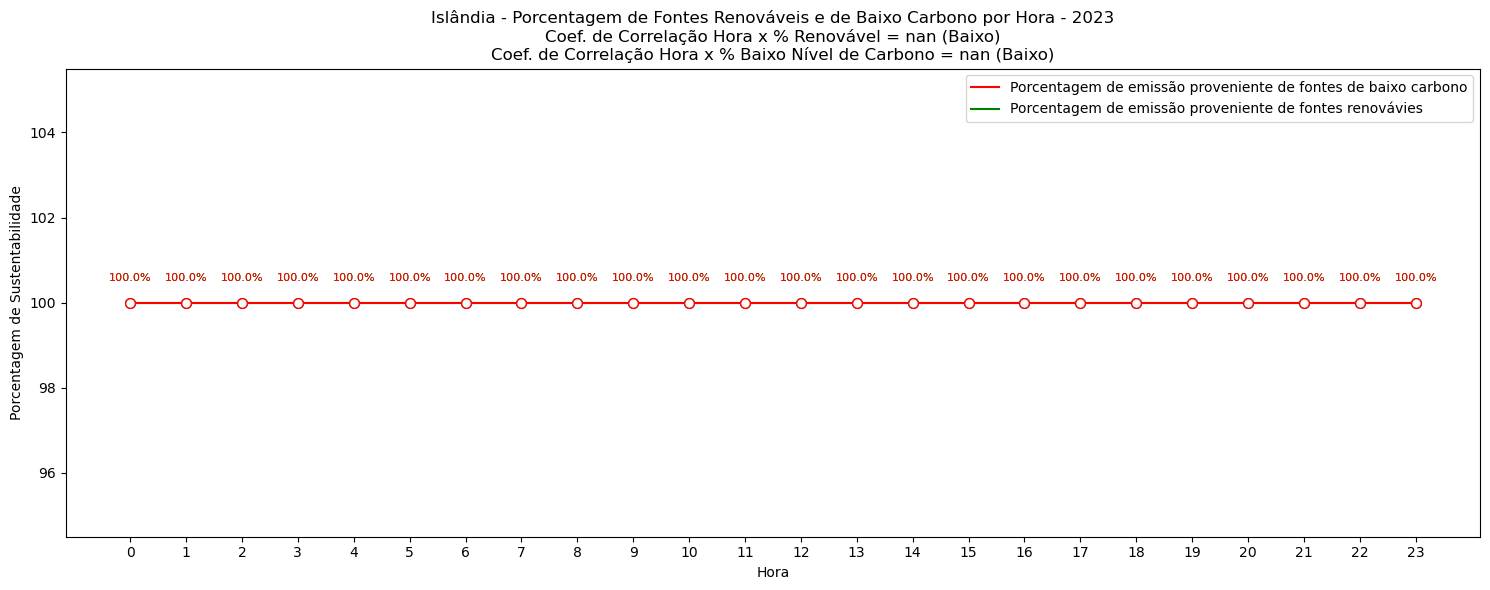

In [ ]:
is_hourly_2023 = is_hourly[is_hourly.year == 2023]

correlation_renewable = is_hourly_2023.hour.corr(is_hourly_2023.avg_renewable_percentage)
correlation_low_carbon = is_hourly_2023.hour.corr(is_hourly_2023.avg_low_carbon_percentage)

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)

plt.plot(is_hourly_2023.hour, is_hourly_2023.avg_renewable_percentage, 
         linewidth=1.5, color='green', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(is_hourly_2023.hour, is_hourly_2023.avg_renewable_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='green')

plt.plot(is_hourly_2023.hour, is_hourly_2023.avg_low_carbon_percentage, 
         linewidth=1.5, color='red', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(is_hourly_2023.hour, is_hourly_2023.avg_low_carbon_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='red')

custom_lines = [
    Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
    Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(
    f'Islândia - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2023\n'
    f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
    f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
)
plt.xlabel('Hora')
plt.ylabel('Porcentagem de Sustentabilidade')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

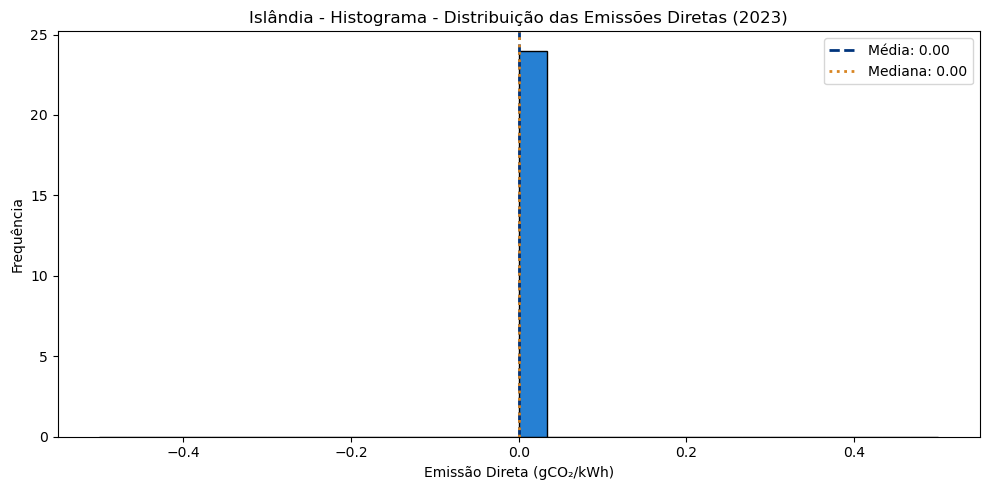

In [184]:
plt.figure(figsize=(10, 5))
plt.hist(is_hourly_2023.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(is_hourly_2023.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {is_hourly_2023.total_direct_carbon_emission.mean():.2f}')
plt.axvline(is_hourly_2023.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {is_hourly_2023.total_direct_carbon_emission.median():.2f}')
plt.title('Islândia - Histograma - Distribuição das Emissões Diretas (2023)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

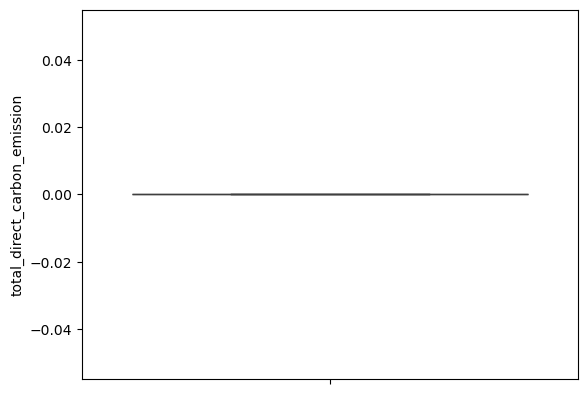

In [185]:
sns.boxplot(is_hourly_2023.total_direct_carbon_emission)

### 2024

c:\Users\mathb\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mathb\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mathb\AppData\Local\Temp\ipykernel_16424\3653876294.py:8: RuntimeWarning: invalid value encountered in scalar divide
  cv = (std/mean)*100


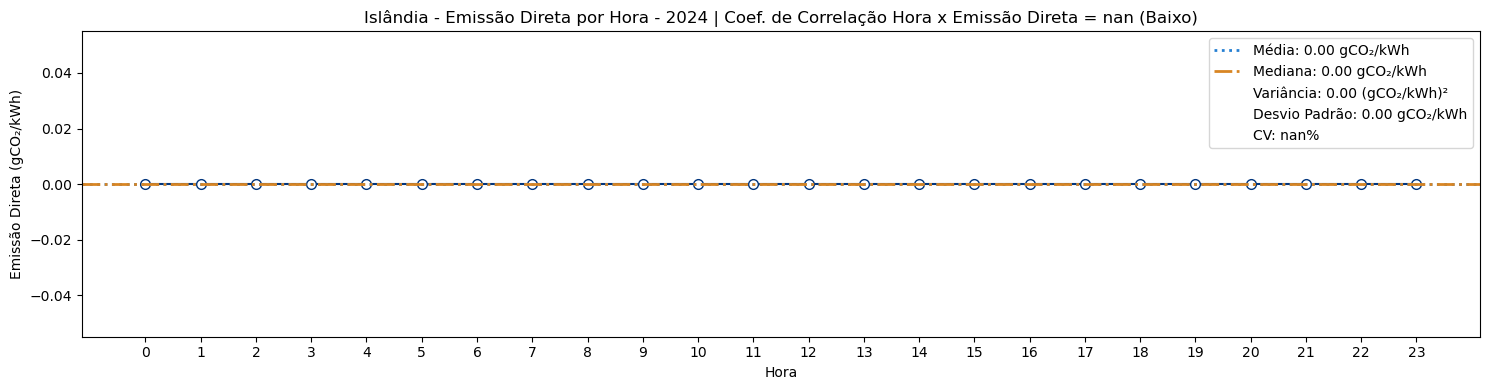

In [186]:
is_hourly_2024 = is_hourly[is_hourly.year == 2024]

correlation = is_hourly_2024.hour.corr(is_hourly_2024.total_direct_carbon_emission)
mean = is_hourly_2024.total_direct_carbon_emission.mean()
median = is_hourly_2024.total_direct_carbon_emission.median()
std = is_hourly_2024.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(is_hourly_2024.hour, is_hourly_2024.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Islândia - Emissão Direta por Hora - 2024 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

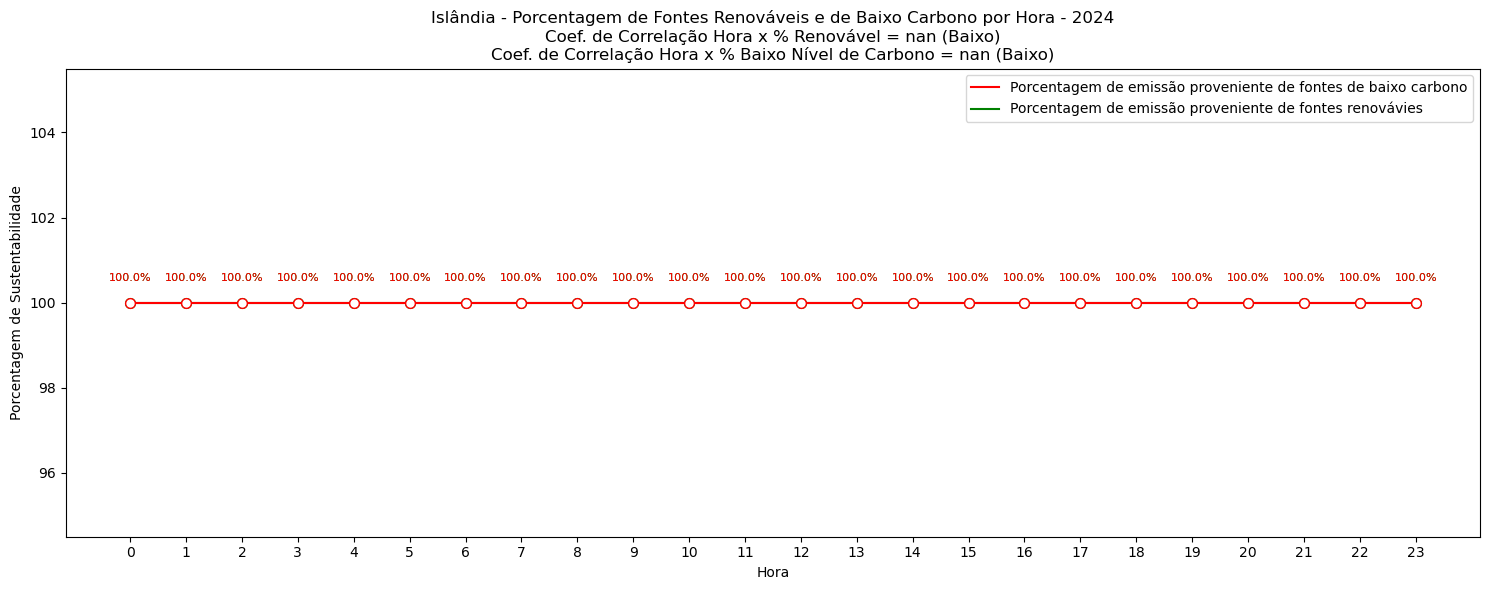

In [ ]:
is_hourly_2024 = is_hourly[is_hourly.year == 2024]

correlation_renewable = is_hourly_2024.hour.corr(is_hourly_2024.avg_renewable_percentage)
correlation_low_carbon = is_hourly_2024.hour.corr(is_hourly_2024.avg_low_carbon_percentage)

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)

plt.plot(is_hourly_2024.hour, is_hourly_2024.avg_renewable_percentage, 
         linewidth=1.5, color='green', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(is_hourly_2024.hour, is_hourly_2024.avg_renewable_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='green')

plt.plot(is_hourly_2024.hour, is_hourly_2024.avg_low_carbon_percentage, 
         linewidth=1.5, color='red', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(is_hourly_2024.hour, is_hourly_2024.avg_low_carbon_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='red')

custom_lines = [
    Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
    Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(
    f'Islândia - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2024\n'
    f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
    f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
)
plt.xlabel('Hora')
plt.ylabel('Porcentagem de Sustentabilidade')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

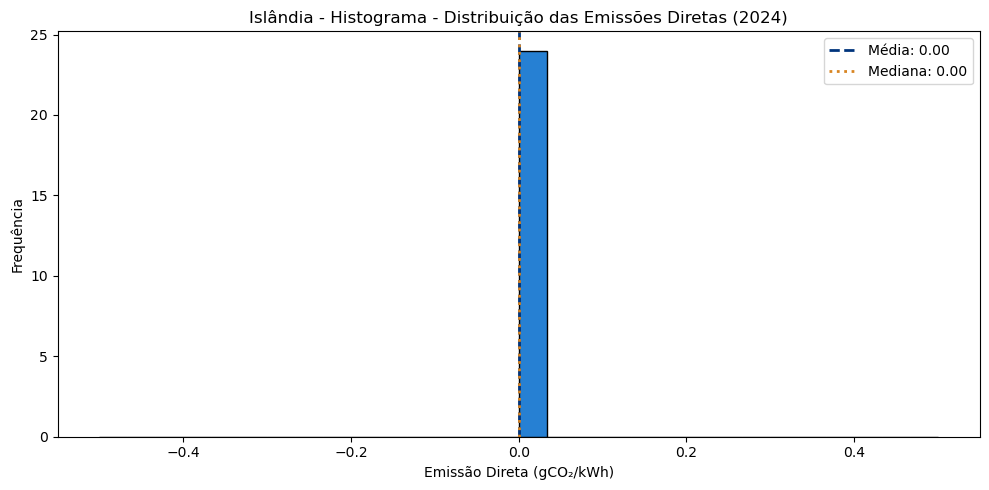

In [188]:
plt.figure(figsize=(10, 5))
plt.hist(is_hourly_2024.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(is_hourly_2024.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {is_hourly_2024.total_direct_carbon_emission.mean():.2f}')
plt.axvline(is_hourly_2024.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {is_hourly_2024.total_direct_carbon_emission.median():.2f}')
plt.title('Islândia - Histograma - Distribuição das Emissões Diretas (2024)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

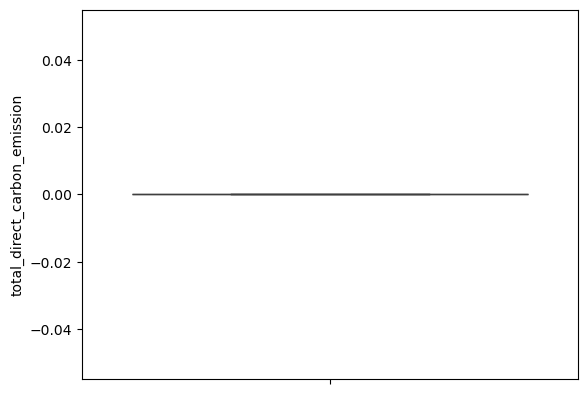

In [189]:
sns.boxplot(is_hourly_2024.total_direct_carbon_emission)